In [ ]:
!pip install -q qiskit
!pip install -q pylatexenc
!pip install -q qiskit_aer
!pip install -q qiskit_ibm_runtime

In [40]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#!pip install --upgrade qiskit


In [ ]:
from qiskit.circuit import Parameter


In [ ]:
# implementing time simulation using trotterisation
# Psi(t)= U(t)Psi(0), U(t) is the time evolution operator
# U(t)= e^(-iHt)
# time evolution is implemented by a series of dt time evolutions(linear trotterisation)
# trotterisation is required because Hamiltonian is a summation of non-commuting operators

# Hamiltonian(H)= J*(XX+YY+ZZ), for two-spin Heisenberg model(isotropic)
# H= J*(summation(X_i X_j + Y_i Y_j + Z_i Z_j)) over [(i,j)=(0,1), (1,2)], for three-spin model
# each pair interacts with Heisenberg exchange — so 2-body interactions only between neighbors
# single entanglement in 2spin, chain entanglement in 3spin

In [ ]:
#parameters
t = 1.0          #total time
r = 5            #trotter steps (increase r for better accuracy)
dt = t / r       #small time step
J = 1

In [ ]:
#create two-spin hamiltonian
def two_spin_hamiltonian(dt):
    qc = QuantumCircuit(2)

    # XX interaction
    qc.h([0,1]) #to convert to Z basis
    qc.cx(0, 1)
    qc.rz(2 * dt, 1)
    qc.cx(0, 1)
    qc.h([0,1]) #reconvert to X basis

    # YY interaction
    qc.sdg(0) #Sadj gate to convert to X basis
    qc.h(0) #convert to Z basis
    qc.sdg(1)
    qc.h(1)
    qc.cx(0, 1)
    qc.rz(2 * dt, 1)
    qc.cx(0, 1)
    qc.h(0) #convert Z to X basis
    qc.s(0) #reconvert to Y basis
    qc.h(1)
    qc.s(1)

    # ZZ interaction
    #gate conjugation — the two CNOTs entangle the qubits such that the Z-rotation on the target becomes a ZZ rotation on the pair.
    qc.cx(0, 1)
    qc.rz(2 * dt, 1)
    qc.cx(0, 1)

    return qc


Measurement counts of 2-spin model: {'01': 189, '10': 835}


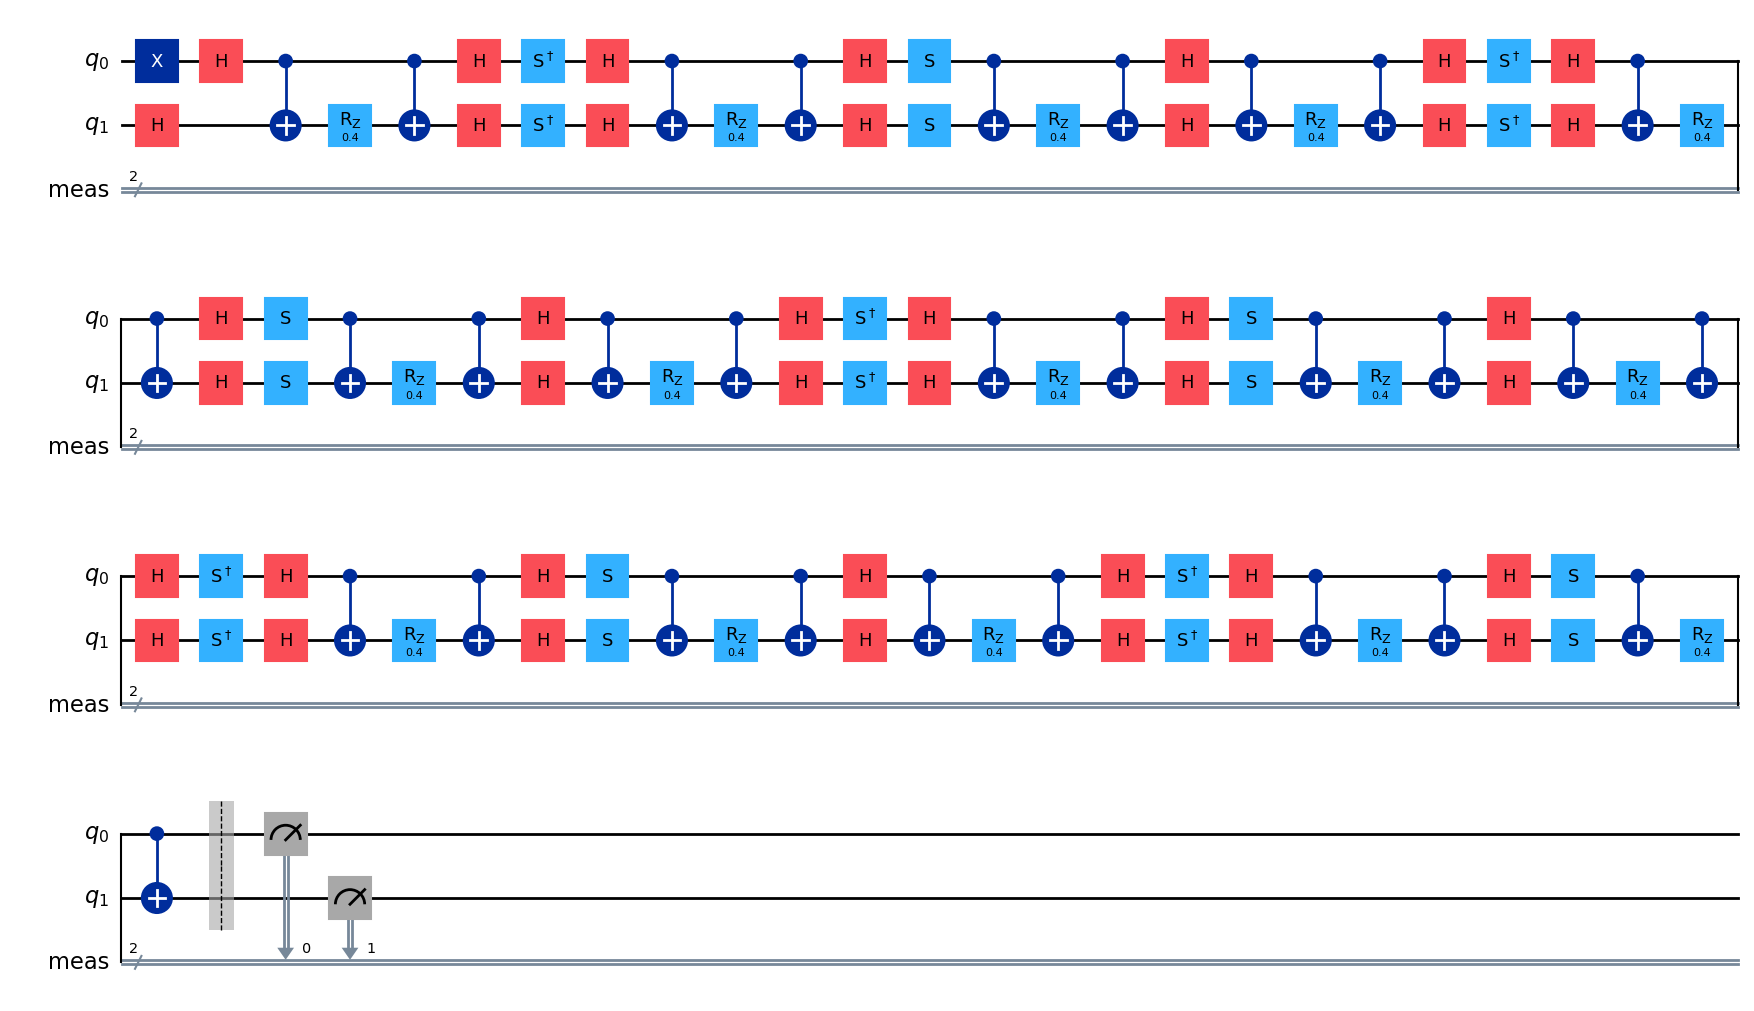

In [ ]:
#build full circuit with repeated steps (apply consecutive dt time evolutions)
evolution_circuit_2spin = QuantumCircuit(2)
evolution_circuit_2spin.x(0)  #example initial state |10>
for _ in range(r):
    evolution_circuit_2spin.compose(two_spin_hamiltonian(dt), inplace=True)

evolution_circuit_2spin.measure_all()

#simulate
sim = AerSimulator()
job_2spin = sim.run(evolution_circuit_2spin)
result = job_2spin.result()
counts = result.get_counts()

print("Measurement counts of 2-spin model:", counts)
evolution_circuit_2spin.draw('mpl')

In [ ]:
def three_spin_hamiltonian(dt):
    qc = QuantumCircuit(3)

    for pair in [(0,1), (1,2)]: #on qubit 0-1 and 1-2
            i, j = pair

            # X_i X_j
            qc.h([i, j])
            qc.cx(i, j)
            qc.rz(-2 * J * dt, j)
            qc.cx(i, j)
            qc.h([i, j])

            # Y_i Y_j
            qc.sdg(i)
            qc.h(i)
            qc.sdg(j)
            qc.h(j)
            qc.cx(i, j)
            qc.rz(2 * dt, j)
            qc.cx(i, j)
            qc.h(i)
            qc.s(i)
            qc.h(j)
            qc.s(j)

            # Z_i Z_j
            qc.cx(i, j)
            qc.rz(-2 * J * dt, j)
            qc.cx(i, j)

    return qc


Measurement counts of 3-spin model: {'111': 76, '100': 739, '001': 209}


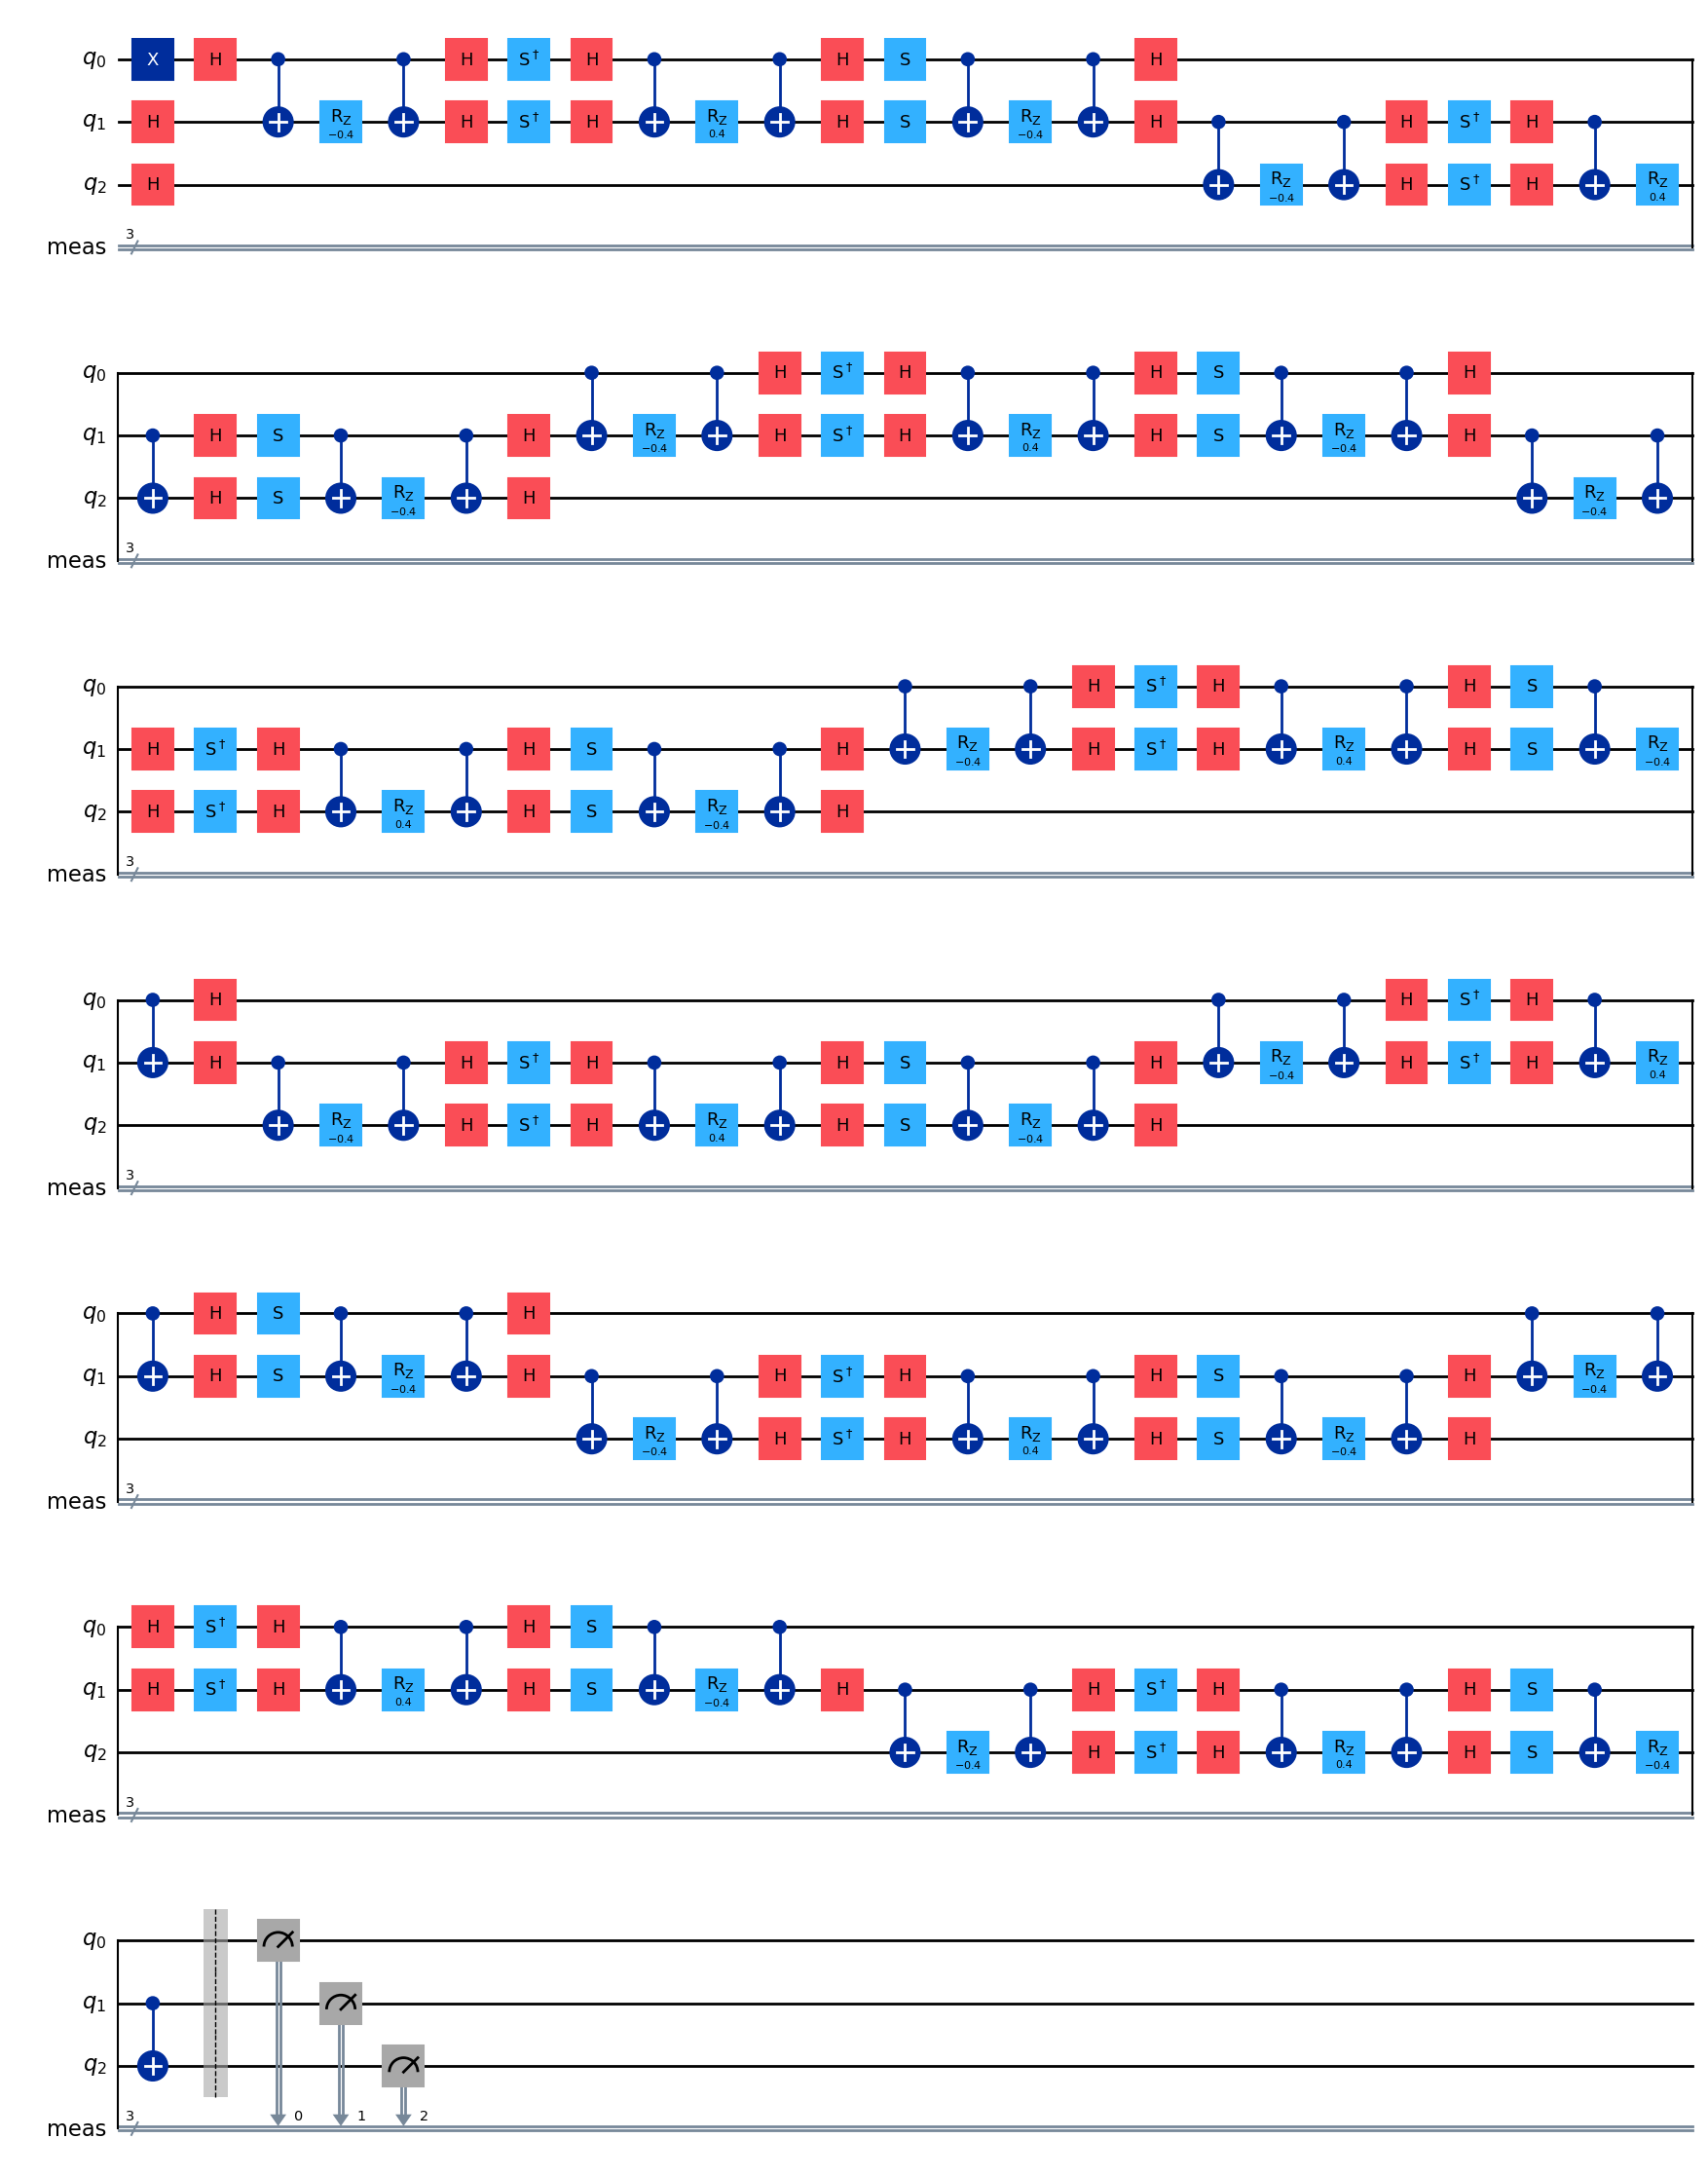

In [ ]:
#build full circuit with repeated steps
evolution_circuit_3spin = QuantumCircuit(3)
evolution_circuit_3spin.x(0)  #example initial state |100>
for _ in range(r):
    evolution_circuit_3spin.compose(three_spin_hamiltonian(dt), inplace=True)

evolution_circuit_3spin.measure_all()

#simulate
sim = AerSimulator()
job_3spin = sim.run(evolution_circuit_3spin)
result = job_3spin.result()
counts = result.get_counts()

print("Measurement counts of 3-spin model:", counts)
evolution_circuit_3spin.draw('mpl')

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, EstimatorV2 as Estimator
from qiskit.quantum_info import Pauli

In [ ]:
from google.colab import userdata
service = QiskitRuntimeService(
    channel="ibm_quantum",
    token= userdata.get('IBM_API_KEY')
)

In [ ]:
backend = service.backend("ibm_sherbrooke")

transpiled_circuit_2spin = transpile(evolution_circuit_2spin, backend)
transpiled_circuit_3spin = transpile(evolution_circuit_3spin, backend)

num_qubits_transpiled_2spin = transpiled_circuit_2spin.num_qubits
num_qubits_transpiled_3spin = transpiled_circuit_3spin.num_qubits

#2-spin observable
#assuming original qubits 0, 1 are mapped to the first two qubits of the transpiled circuit
observable_2spin = Pauli("I" * (num_qubits_transpiled_2spin - 2) + "ZZ")

#3-spin observable
#assuming original qubits 0, 1, and 2 are mapped to the first three qubits of the transpiled circuit
observable_3spin = Pauli("I" * (num_qubits_transpiled_3spin - 3) + "ZZI")

est= Estimator(backend)
#run transpiled circuits
job1 = est.run([(transpiled_circuit_2spin, observable_2spin)])
job2 = est.run([(transpiled_circuit_3spin, observable_3spin)])



In [48]:
#expectation value of the ZZ observable for the transpiled 2spin circuit
print(job1.result()[0].data.evs)

#expectation value of the ZZI observable for the transpiled 3spin circuit
print(job2.result()[0].data.evs)

1.0174385594938762
1.0116850496887626


In [ ]:
#the value 1.017 being close to +1 suggests that state after the evolution circuit is largely projected onto the |00> or |11> subspace.
#slight deviation from exactly 1 could be due to noise on the real hardware or the approximation introduced by the finite number of Trotter steps
#similarly for 3spin

In [ ]:

'''
#on real hardware

provider = IBMProvider()
backend = provider.get_backend('ibmq_qasm_simulator')
job_2spin = backend.run(transpile(evolution_circuit_2spin, backend), shots=1024)
job_3spin = backend.run(transpile(evolution_circuit_3spin, backend), shots=1024)

result_2spin = job_2spin.result()
result_3spin = job_3spin.result()
count_2spin = result_2spin.get_counts()
count_3spin = result_3spin.get_counts()

print("Measurement counts of 2-spin model:", count_2spin)
print("Measurement counts of 3-spin model:", count_3spin)

'''